# Summary
## Data Preparation Assumptions
The following assumptions are used during the data processing process before the data is ready for model.
1. The energy price can be negative in reality and is not removed as abnormality. 
2. The energy price hikes are possible in reality and is not removed as abnormality. 
3. Only one weather profile is used for each state. The weather profile between two adjacent states are kept even when they have high linear correlation.
## Model Summary
The following models are implemented
1. Non-probablistic Baseline: to help tune the probablist model in the later, I start to build a non-probabalistic baseline predictor. The XGBoost tree models are considerd for this purpose.
2. Probablistic XGBoost: here I integrated a quantile loss function to train the XGBoost model, in order to estimate a specific percentile (i.e., quantile) of the target variable.
3. Bayesian Neural Network: here I build a bayesain neural network model to estimate the distributions of model parameters.


# Table of Contents
1. [Introduction](#1-introduction)
2. [Data Preparation](#2-Data-preparation)
3. [Multi-variate Multi-step Time Series Forecasting](#3-Multi-variate-Multi-step-time-Series-Forecasting)
4. [Conclusion and Limitations](#4-Conclusion-and-Limitations)

# 1 Introduction
This task is about to predict time series with uncertainty.

We'd like to construct a predictive model that forcasts prices with uncertainty ranges for electricity at each of the targer nodes. We're looking for 24-hour ahead forcasts for the last month of data.
Your model should ideally also account for any potentail underlying relationship across nodes.
Finally, please process evaluation metrics for this excercise, explaining your reasoning, and quantify the model performance against your chosen metrics.

In [1]:
import pandas as pd
import matplotlib 
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns
import tqdm

# import statsmoddels for analysis
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss, ccf


# 2. Data Preparation

## 2.1 Data Loader 
This section loads the data and has a first inspection about the data to understand the shape of data, and the existence of NANs.

The dataset is a date-time indexed table with 41 columns, and no NANs and duplicates are detected in the data. 

We can observe negative energy price at some datapoints.

In [2]:
data_file = "model_ready.parquet"

df = pd.read_parquet(data_file, "pyarrow")
df.head()
df.info()

print(df.describe())

df.isnull().sum().any()
df.duplicated(keep="first").sum()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17497 entries, 2021-07-31 01:00:00 to 2021-07-31 00:00:00
Data columns (total 41 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   central_mtlf_fc                      17497 non-null  float64
 1   north_mtlf_fc                        17497 non-null  float64
 2   south_mtlf_fc                        17497 non-null  float64
 3   system_mtlf_fc                       17497 non-null  float64
 4   ia_ksux_ws_mph_fc                    17497 non-null  float64
 5   il_kmdw_ws_mph_fc                    17497 non-null  float64
 6   il_kord_ws_mph_fc                    17497 non-null  float64
 7   mi_kanj_ws_mph_fc                    17497 non-null  float64
 8   mi_karb_ws_mph_fc                    17497 non-null  float64
 9   mi_kazo_ws_mph_fc                    17497 non-null  float64
 10  mi_klan_ws_mph_fc                    17497 non-null  float6

0

## 2.2 Data Cleaning
The data seems not clean.

### 2.2.1 Nonincreasing Time Series Index


In [3]:
# nonincreasing time series index
print(df.index[:5])
print(df.index[-5:])
# sort index by datatimeindex
df = df.sort_index()

# the frequency of the datatime index is not set. based on inspection, it is sampled hourly. here i will set the frequency to 1 hour in case in the future i may need to resample the data.
df = df.asfreq('H')
print(df.index[:5])
print(df.index[-5:])


DatetimeIndex(['2021-07-31 01:00:00', '2021-07-31 02:00:00',
               '2021-07-31 03:00:00', '2021-07-31 04:00:00',
               '2021-07-31 05:00:00'],
              dtype='datetime64[ns]', name='interval_ending_dt_utc', freq=None)
DatetimeIndex(['2021-07-30 20:00:00', '2021-07-30 21:00:00',
               '2021-07-30 22:00:00', '2021-07-30 23:00:00',
               '2021-07-31 00:00:00'],
              dtype='datetime64[ns]', name='interval_ending_dt_utc', freq=None)
DatetimeIndex(['2019-09-01 00:00:00', '2019-09-01 01:00:00',
               '2019-09-01 02:00:00', '2019-09-01 03:00:00',
               '2019-09-01 04:00:00'],
              dtype='datetime64[ns]', name='interval_ending_dt_utc', freq='H')
DatetimeIndex(['2021-08-29 20:00:00', '2021-08-29 21:00:00',
               '2021-08-29 22:00:00', '2021-08-29 23:00:00',
               '2021-08-30 00:00:00'],
              dtype='datetime64[ns]', name='interval_ending_dt_utc', freq='H')


### 2.2.2 Abnormality Check
note i will not remove abnormality even if there are some.
in real energy markets, the energy price can be more than 100 times higher than the normal energy price when there are contingencies in the grid. One example is the whole sale market price in Texas during 2021/3 when the grid was hit by an extreme snow storm.
as a pratical predictor, this abnormality should be predicted if possible.

## 2.3 More Inspection with Physics

The dataset contains 17497 samples at an interval of 1 hour with 41 columns, 38 of which are features and the other 3 are targets representing electricity prices at three different nodes in the grid. 
Some vailable explantion of the columns:

- "mtfl": energy use 
- "ws": wind speed?
- "td": outdoor dew point temperature 

The data seems related to the MISO power grid, but with additionally data difficult to understand.
Physically, MISO covers all or a portion of 15 states (AR, IL, IN, IA, KY, LA, MI, MN, MS, MO, MT, ND, SD, TX, and WI) as well as the Canadian province of Manitoba. MISO is interconnected with Pennsylvania-New Jersey-Maryland Interconnection (PJM) to the east and the Southwest Power Pool (SPP) to the southwest, the Southestern Reginoal Transmission Planning (SERC) to the southeast.
OH is under PJM, OK is under SPP and SC is under SERC during normal hours when there are no contigency.
Once there is contigency, PJM and SPP can buy/sell power to MISO.

### 2.3.1 Energy Use
Some physics about Energy use:
- nonnegative values
- conservation. This may be hard to get from the given dataset without a detailed graph representation of each node in the grid. But we can give a try to see how the energy is related in the given data set.

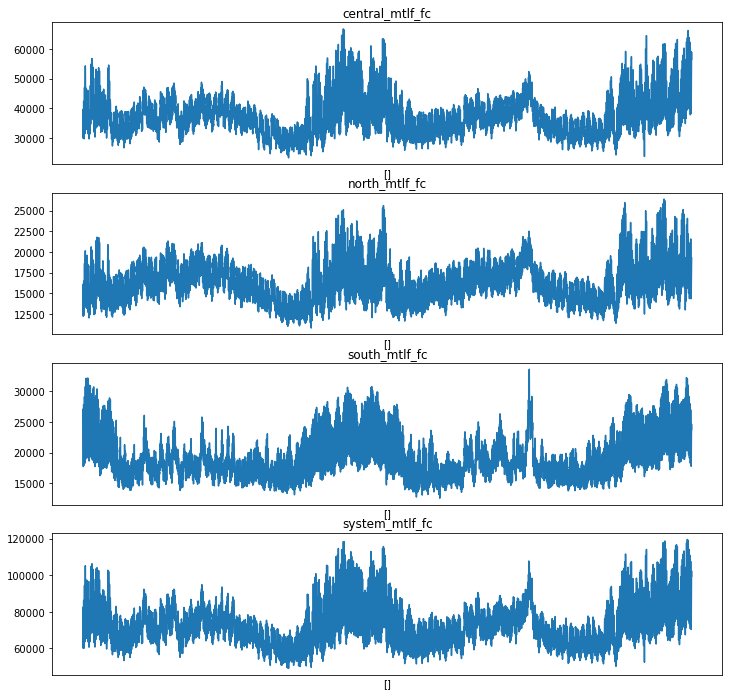

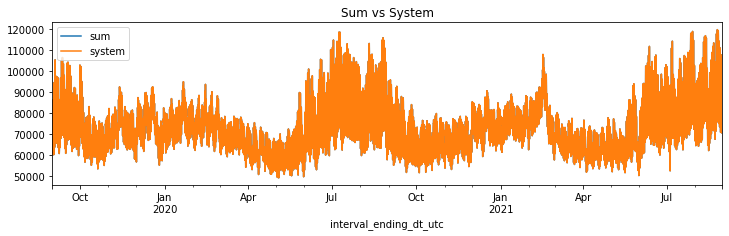

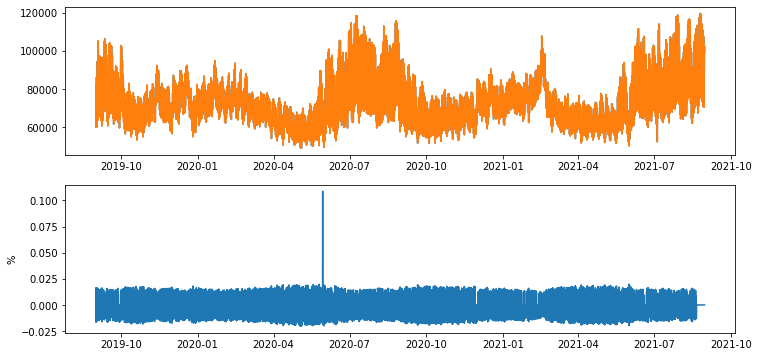

In [4]:
# plot the time series
energy_names = [] 
for name in df.columns:
    if "mtlf" in name:
        energy_names.append(name)
df_energy = df[energy_names]

n_energy = len(energy_names)
plt.figure(figsize=(12,3*n_energy))
for i, name in enumerate(energy_names):
    plt.subplot(n_energy, 1, i+1)
    plt.plot(df.index, df[name])
    plt.title(name)
    plt.xlabel([])
    plt.xticks([])
plt.show()

# just by naming, can we assume 'central_mtlf_fc' + 'north_mtlf_fc' + 'south_mtlf_fc' = 'system_mtlf_fc'??
area_sum = pd.DataFrame()
area_sum['sum'] = df[['central_mtlf_fc', 'north_mtlf_fc', 'south_mtlf_fc']].sum(axis=1)
area_sum['system'] = df['system_mtlf_fc']
area_sum.plot(figsize=(12,3))
plt.title("Sum vs System")
plt.show()

plt.figure(figsize=(12,6))
plt.subplot(211)
plt.plot(area_sum['sum'])
plt.plot(area_sum['system'])

plt.subplot(212)
plt.plot((area_sum['system'] - area_sum['sum'])/area_sum['sum']*100)
plt.ylabel("%")
plt.show()


### 2.3.2 Wind Speed



{'ia': ['ia_ksux_ws_mph_fc'], 'il': ['il_kmdw_ws_mph_fc', 'il_kord_ws_mph_fc'], 'mi': ['mi_kanj_ws_mph_fc', 'mi_karb_ws_mph_fc', 'mi_kazo_ws_mph_fc', 'mi_klan_ws_mph_fc'], 'mn': ['mn_kinl_ws_mph_fc', 'mn_krst_ws_mph_fc'], 'mo': ['mo_kstl_ws_mph_fc'], 'oh': ['oh_kakr_ws_mph_fc'], 'ok': ['ok_kclk_ws_mph_fc', 'ok_kokc_ws_mph_fc', 'ok_ktul_ws_mph_fc', 'ok_kwdg_ws_mph_fc'], 'sc': ['sc_kchs_ws_mph_fc']}


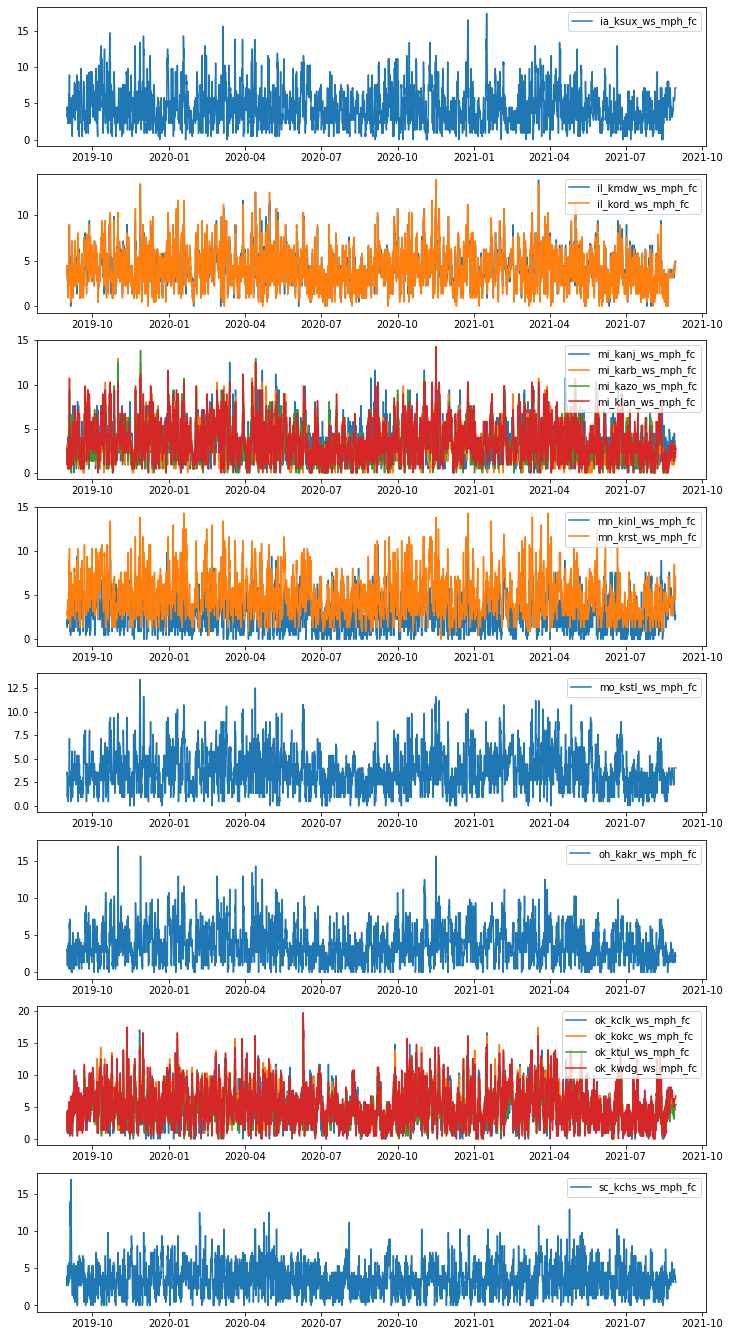

In [5]:
# get all the wind speed data
wind_names = []
for name in df.columns:
    if "_ws_mph_fc" in name:
        wind_names.append(name)

# group wind speed data by states in case in the future i want to a feature engineering for each target (price at a specific state/node) prediction
# get all the states, and save (state, [ws_names]) as hash table for future use 
wind_groups = {}
for name in wind_names:
    state = name.split('_')[0]
    if state not in wind_groups:
        wind_groups[state] = [name]
    else:
        wind_groups[state] += [name]
print(wind_groups)

# plot windspeed by states to see if there is any duplicates
n_states = len(wind_groups.keys())
plt.figure(figsize=(12, n_states*3))
for i, state in enumerate(wind_groups.keys()):
    plt.subplot(n_states, 1, i+1)
    for name in wind_groups[state]:
        plt.plot(df[name], label=name)
    plt.legend()
plt.show()


### 2.3.2 Dewpoint Temperature
Dewpoint temperature relates to the demand of the grid, and thus the supply.

Some physics about dewpoint temperature:

{'ar': ['ar_kjbr_td_f_fc'], 'ia': ['ia_kdsm_td_f_fc', 'ia_ksux_td_f_fc'], 'in': ['in_kfwa_td_f_fc', 'in_kind_td_f_fc', 'in_klaf_td_f_fc', 'in_ksbn_td_f_fc'], 'ky': ['ky_ksdf_td_f_fc'], 'la': ['la_kbtr_td_f_fc', 'la_klch_td_f_fc', 'la_kshv_td_f_fc'], 'mi': ['mi_klan_td_f_fc'], 'mn': ['mn_kinl_td_f_fc', 'mn_kpqn_td_f_fc'], 'mo': ['mo_ksgf_td_f_fc', 'mo_kstl_td_f_fc'], 'oh': ['oh_kluk_td_f_fc'], 'ok': ['ok_klaw_td_f_fc']}


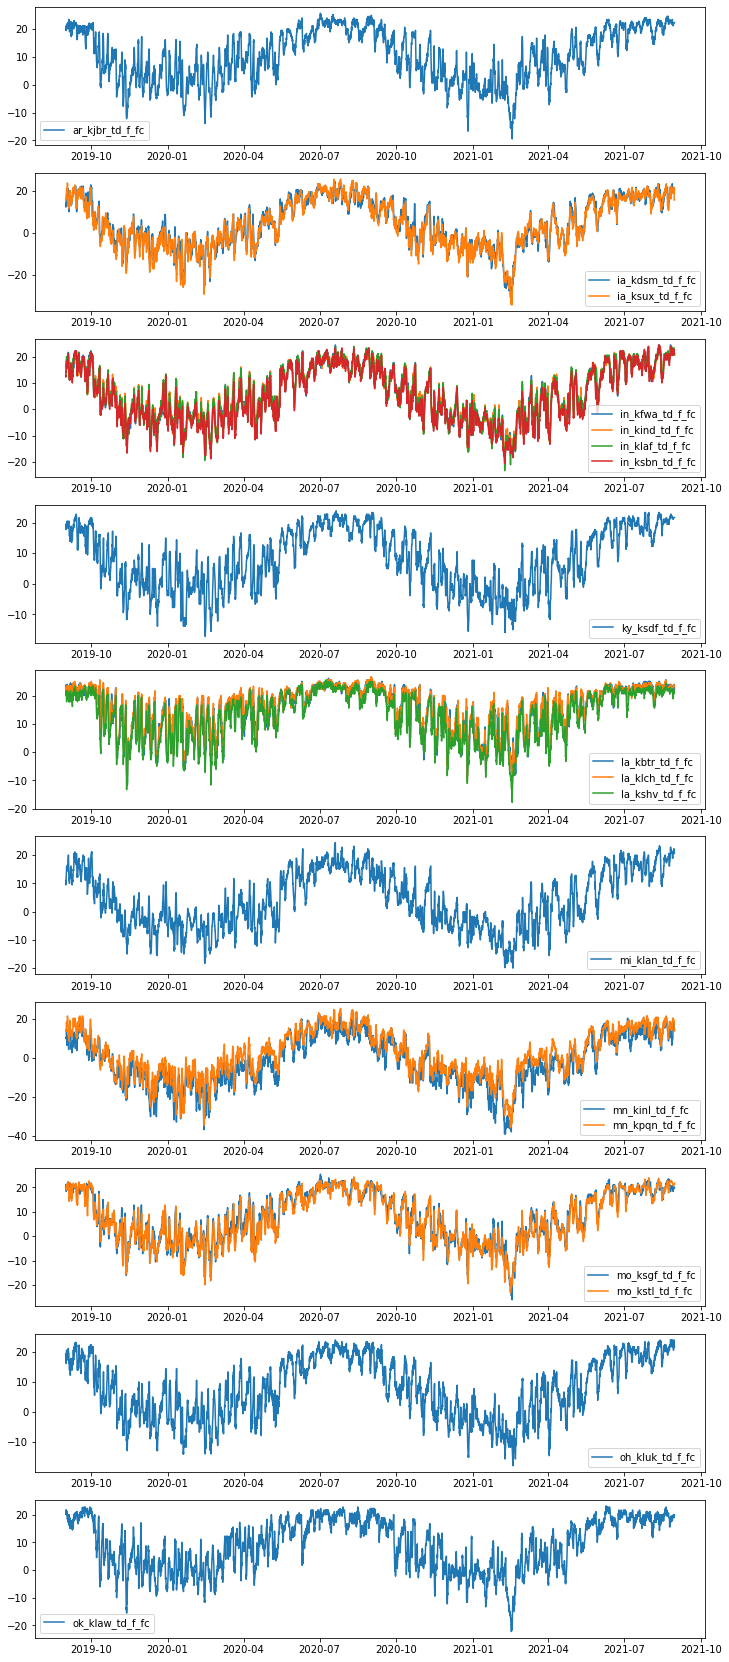

In [6]:
# get all the dewpoint 
dew_names = []
for name in df.columns:
    if "td_f_fc" in name:
        dew_names.append(name)

# group wind speed data by states in case in the future i want to a feature engineering for each target (price at a specific state/node) prediction
# get all the states, and save (state, [ws_names]) as hash table for future use
dew_groups = {}
for name in dew_names:
    state = name.split('_')[0]
    if state not in dew_groups:
        dew_groups[state] = [name]
    else:
        dew_groups[state] += [name]
print(dew_groups)

# plot windspeed by states to see if there is any duplicates
n_states = len(dew_groups.keys())
plt.figure(figsize=(12, n_states*3))
for i, state in enumerate(dew_groups.keys()):
    plt.subplot(n_states, 1, i+1)
    for name in dew_groups[state]:
        plt.plot(df[name], label=name)
    plt.legend()
plt.show()


### 2.3.4 Price


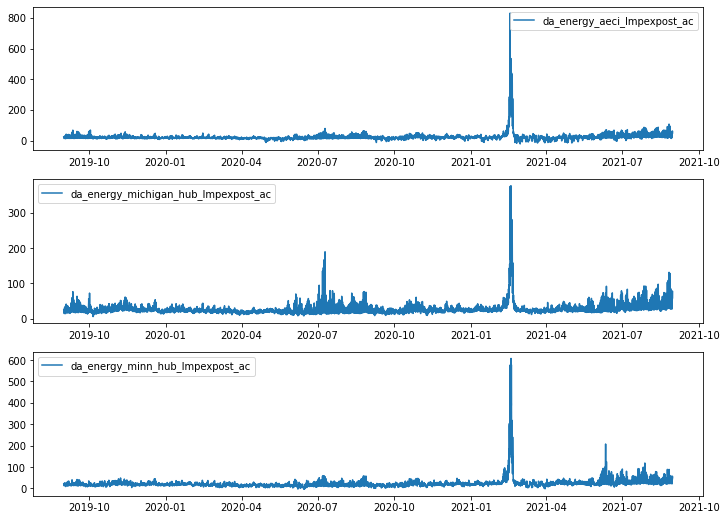

/Users/yangyangfu/miniconda3/envs/ml-pytorch/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/yangyangfu/miniconda3/envs/ml-pytorch/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


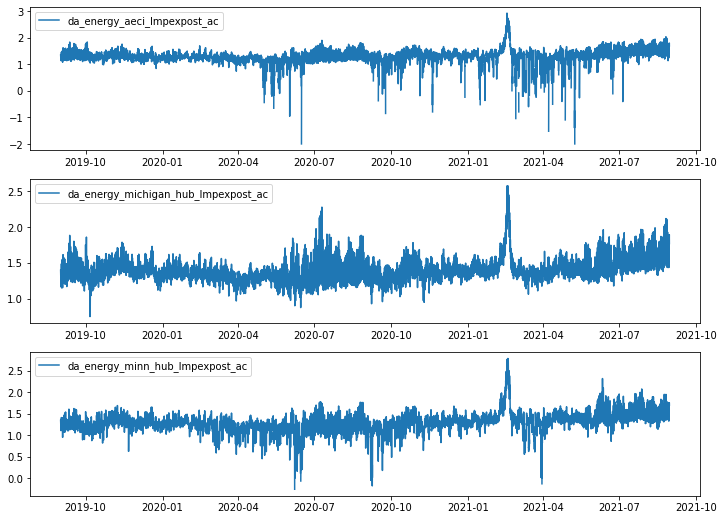

In [7]:
target_names = []
for name in df.columns:
    if "da_energy" in name:
        target_names.append(name)

n_targets = len(target_names)
plt.figure(figsize=(12, n_targets*3))
for i, target in enumerate(target_names):
    plt.subplot(n_targets, 1, i+1)
    plt.plot(df[target], label=target)
    plt.legend()
plt.show()

# the price changes to dramastically at some point, lets do a log plot: this is weired. the price at some point is negative. how to do log?
plt.figure(figsize=(12, n_targets*3))
for i, target in enumerate(target_names):
    plt.subplot(n_targets, 1, i+1)
    plt.plot(np.log10(df[target]), label=target)
    plt.legend()
plt.show()


The same sensor such as windspeed and dewpoint temperature at the same state although different locations has very high correlation. From plots, they are almost the same.
Consider remove the colinearity in the data for a supervised learning.

## 2.4 Decomposition and Stationary Tests

<Figure size 432x288 with 0 Axes>

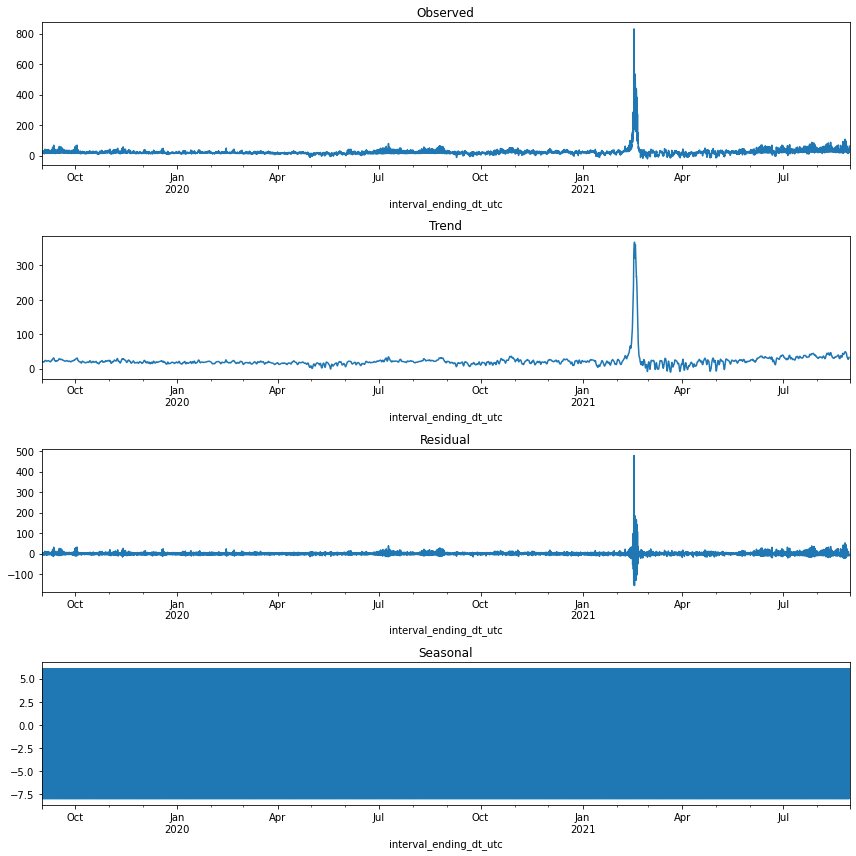

<Figure size 432x288 with 0 Axes>

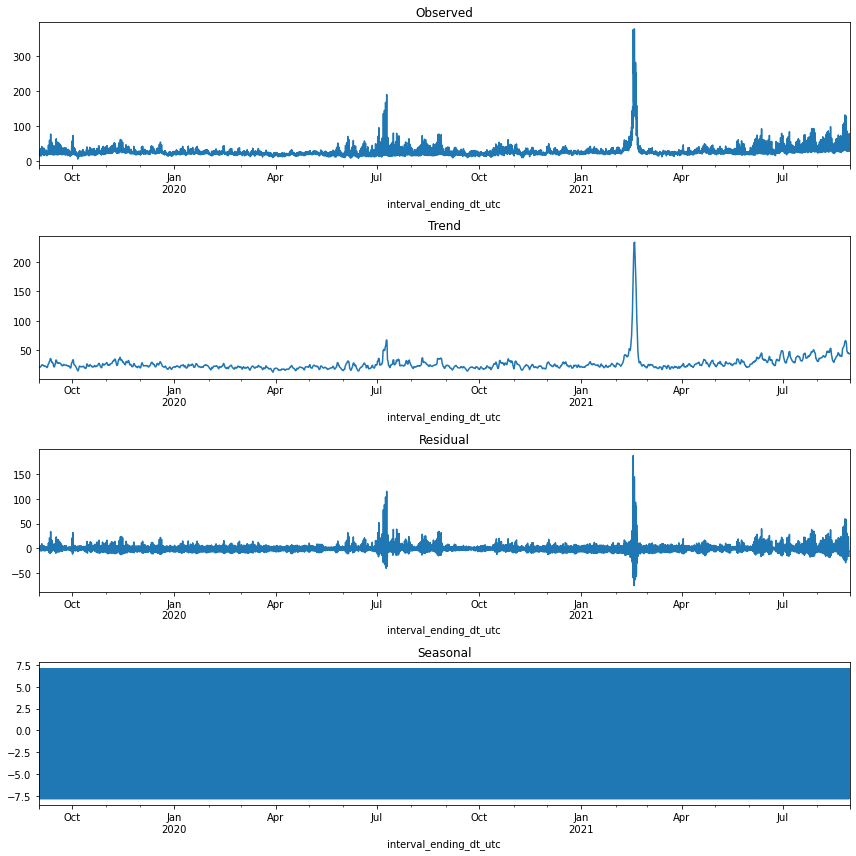

<Figure size 432x288 with 0 Axes>

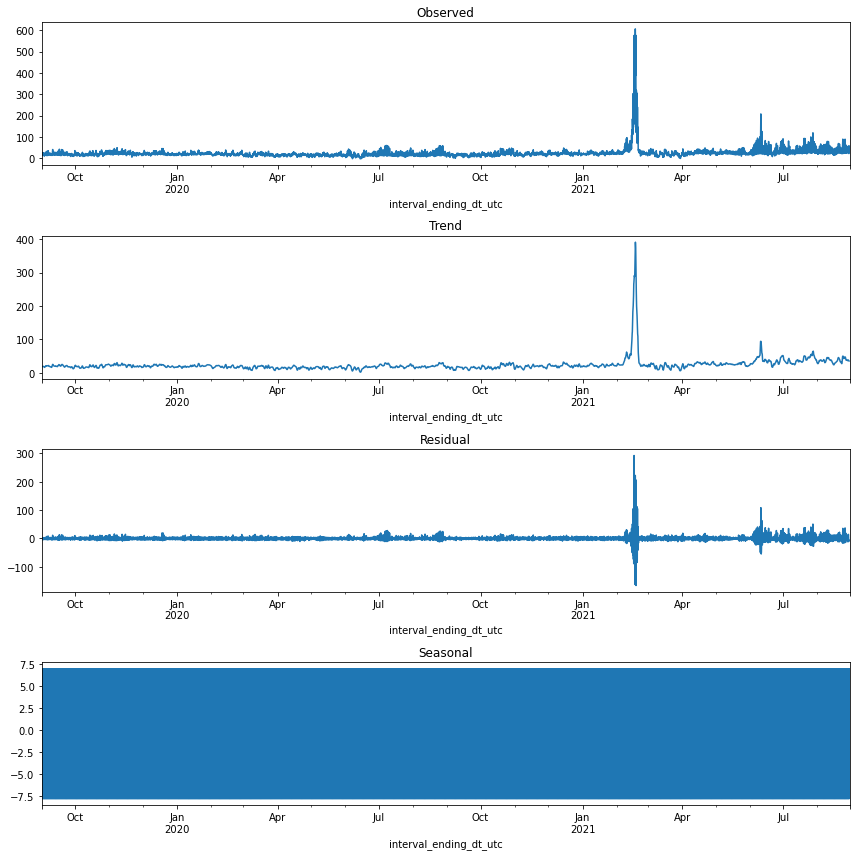

In [8]:
# Decompose the electricity price time series
for i, target in enumerate(target_names):
    res = sm.tsa.seasonal_decompose(df[target], model='additive')
    plt.figure(i)
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 12))
    res.observed.plot(ax=ax1, title='Observed')
    res.trend.plot(ax=ax2, title='Trend')
    res.resid.plot(ax=ax3, title='Residual')
    res.seasonal.plot(ax=ax4, title='Seasonal')
    plt.tight_layout()
    plt.show()


<Figure size 432x288 with 0 Axes>

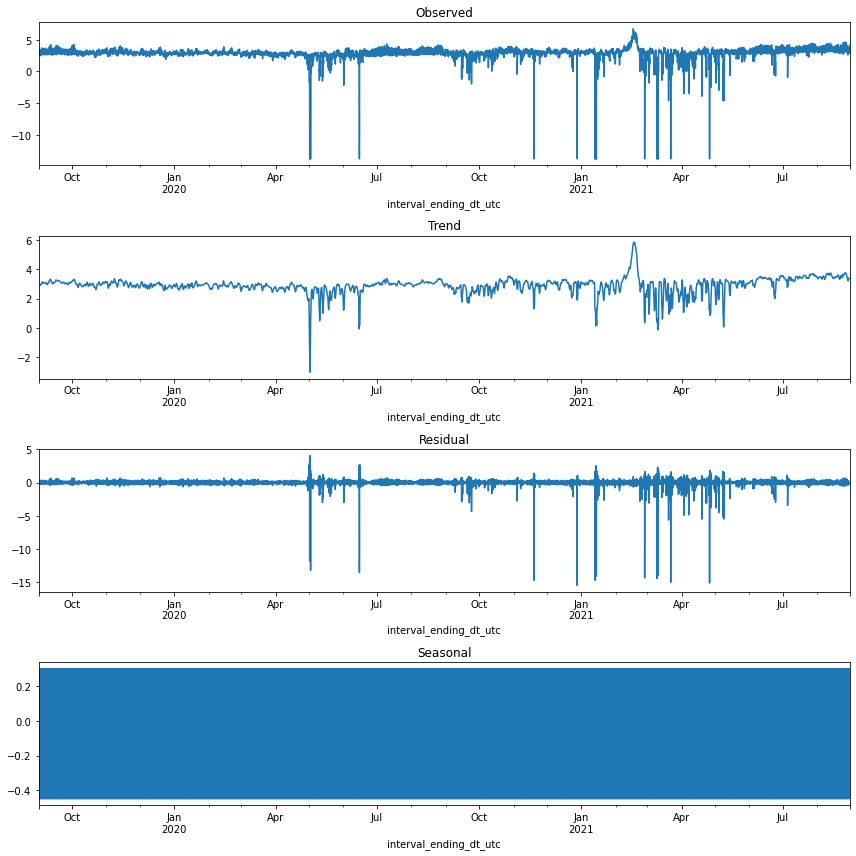

<Figure size 432x288 with 0 Axes>

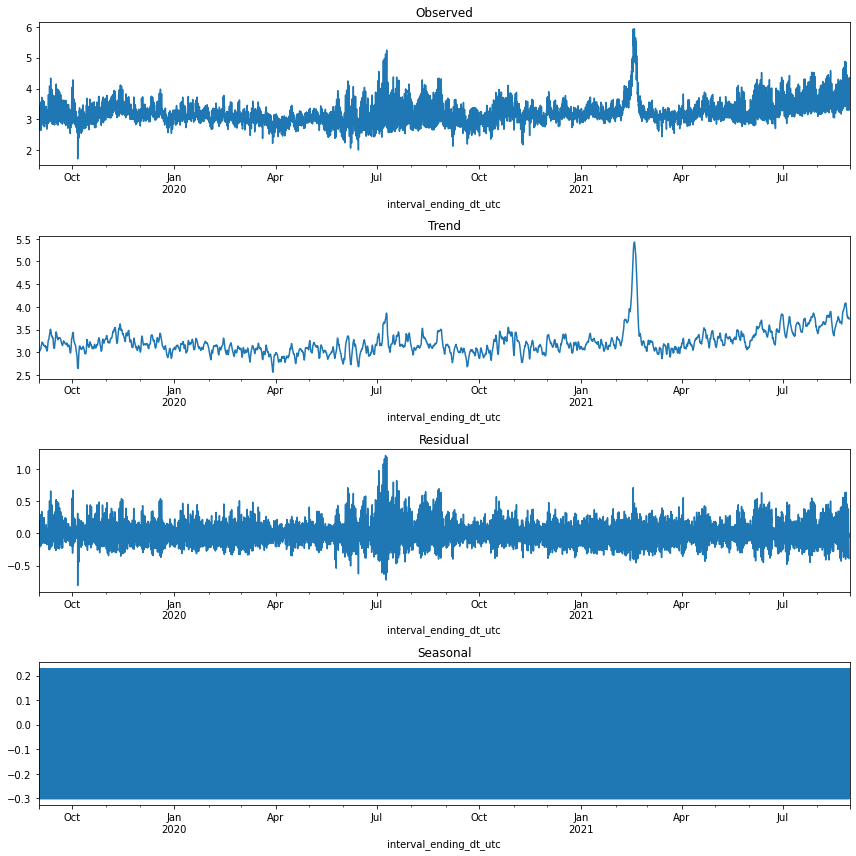

<Figure size 432x288 with 0 Axes>

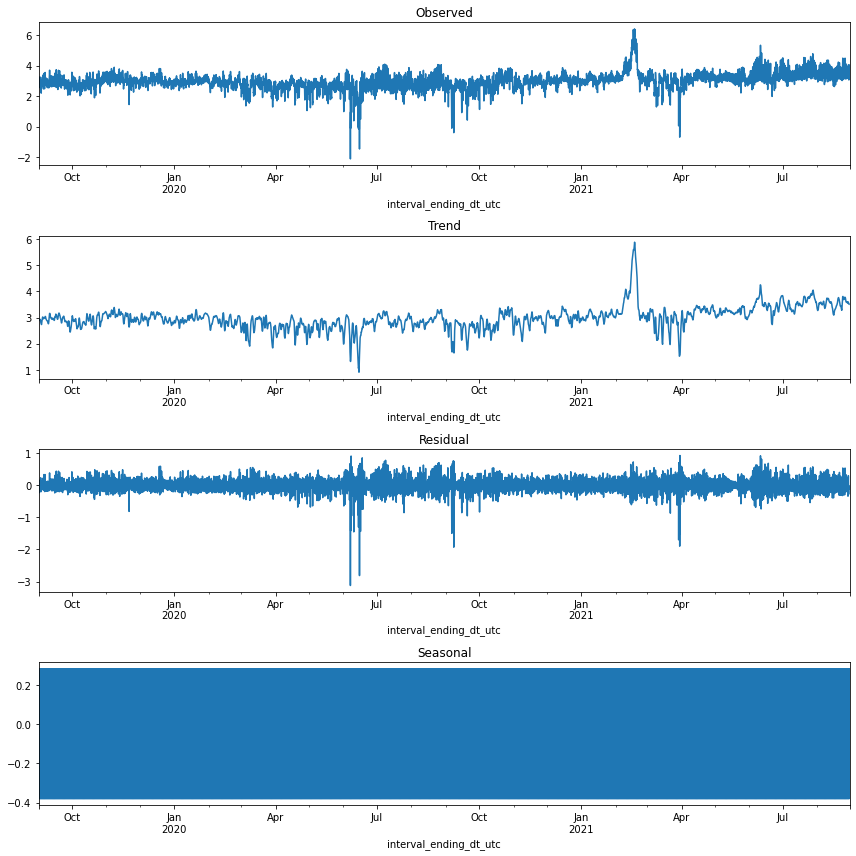

In [9]:
# Decompose the log electricity price time-series
for i, target in enumerate(target_names):
    res = sm.tsa.seasonal_decompose(np.log(df[target].abs()+1e-06), model='additive')
    plt.figure(i)
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 12))
    res.observed.plot(ax=ax1, title='Observed')
    res.trend.plot(ax=ax2, title='Trend')
    res.resid.plot(ax=ax3, title='Residual')
    res.seasonal.plot(ax=ax4, title='Seasonal')
    plt.tight_layout()
    plt.show()

ADF test determines how strongly a time series is defined by a trend. Its hypotheses are the following:
- **Null Hypothesis** $H_{0}$: There is a unit root in the time series, i.e. the series is autocorrelated with (r=1), a time dependent structure and thus, is not stationary.
- **Alternate Hypothesis** $H_{1}$: The time series has no unit root and is either stationary or can be made stationary using differencing.

In [10]:
for target in target_names:
    y = df[target]
    adf_test = adfuller(y, regression='c')
    print('ADF Statistic: {:.6f}\np-value: {:.6f}\n#Lags used: {}'
        .format(adf_test[0], adf_test[1], adf_test[2]))
    for key, value in adf_test[4].items():
        print('Critical Value ({}): {:.6f}'.format(key, value))


ADF Statistic: -9.442901
p-value: 0.000000
#Lags used: 43
Critical Value (1%): -3.430725
Critical Value (5%): -2.861706
Critical Value (10%): -2.566858
ADF Statistic: -10.994541
p-value: 0.000000
#Lags used: 43
Critical Value (1%): -3.430725
Critical Value (5%): -2.861706
Critical Value (10%): -2.566858
ADF Statistic: -9.517134
p-value: 0.000000
#Lags used: 44
Critical Value (1%): -3.430725
Critical Value (5%): -2.861706
Critical Value (10%): -2.566858


The ADF statistic for all three targets are around -9.5, which is less than the critical value at 1% (-3.431) and thus, we can say that **we reject the null hypothesis $H_{0}$ with a significance level 1%**, meaning that there is not a root-unit in the time series and thus, that it is either stationary or could be made stationary with 1st order differencing (difference-stationary).

## 2.5 Autocorrelation, Partial Correlation and Cross-Correlation

/Users/yangyangfu/miniconda3/envs/ml-pytorch/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


<Figure size 432x288 with 0 Axes>

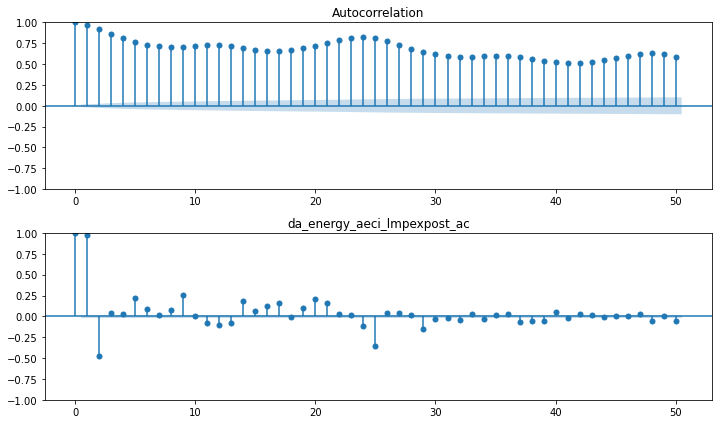

/Users/yangyangfu/miniconda3/envs/ml-pytorch/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


<Figure size 432x288 with 0 Axes>

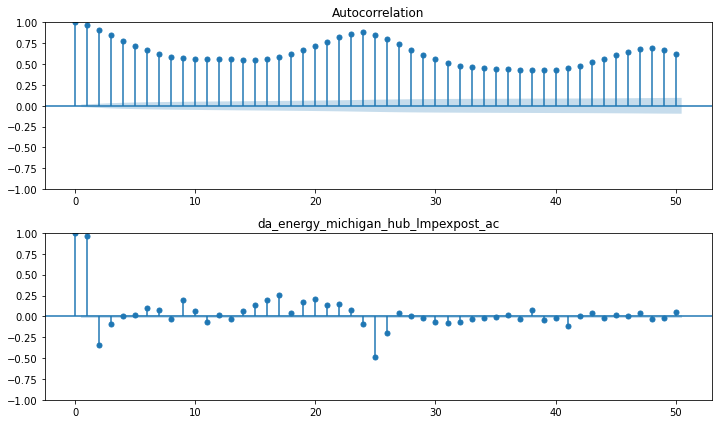

/Users/yangyangfu/miniconda3/envs/ml-pytorch/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


<Figure size 432x288 with 0 Axes>

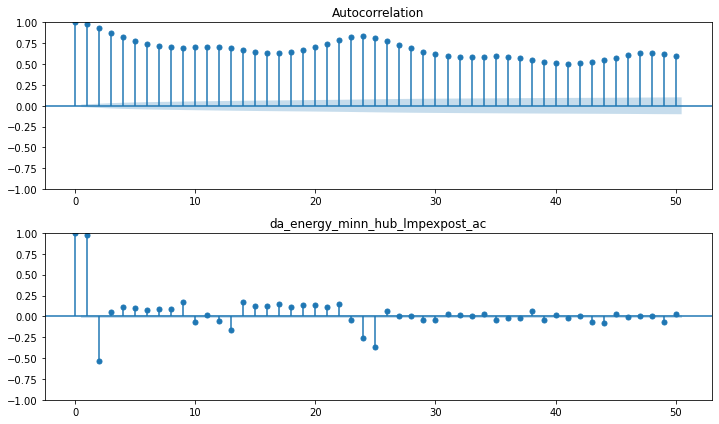

In [11]:
for i, target in enumerate(target_names):
    plt.figure(i)
    fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 6))
    plot_acf(df[target], lags=50, ax=ax1)
    plot_pacf(df[target], lags=50, ax=ax2)
    plt.title(target)
    plt.tight_layout()
    plt.show()


The partial autocorrelation plot of the eletricity price time series shows that the direct relationship between an observation at a given hour (t) is strongest with the observations at t-1, t-2, t-24 time-steps and diminishes afterwards. Thus, we are going to use the 24 previous values of each time series which will constitute a feature for our models. 

Nevertheless, it would quite definitely be more beneficial if we only chose to use specific past values (observations at certain time-lags) of a given feature, based on the cross-correlation between the electricity price and each one of the features in the dataset. For example, below we can see the cross-correlation between the electricity price and the total load. We see that there are many time-lags with a correlation which is close to zero and could be ommited. 

In [12]:
# Find the correlations between the electricity price and the rest of the features
feature_names = df.columns.to_list()
for target in target_names:
    feature_names.remove(target)

for i, target in enumerate(target_names):
    names = feature_names + [target]
    correlations = df[names].corr(method='pearson')
    print(correlations[target].sort_values(ascending=False).to_string())


da_energy_aeci_lmpexpost_ac    1.000000
system_mtlf_fc                 0.417707
south_mtlf_fc                  0.410610
central_mtlf_fc                0.390246
north_mtlf_fc                  0.377514
sc_kchs_ws_mph_fc              0.069237
mi_karb_ws_mph_fc              0.025798
oh_kakr_ws_mph_fc              0.005464
mi_kanj_ws_mph_fc             -0.002272
mi_kazo_ws_mph_fc             -0.012842
mi_klan_ws_mph_fc             -0.015874
ok_kwdg_ws_mph_fc             -0.017892
mo_kstl_ws_mph_fc             -0.032532
il_kmdw_ws_mph_fc             -0.034431
ky_ksdf_td_f_fc               -0.037490
mi_klan_td_f_fc               -0.039438
il_kord_ws_mph_fc             -0.041255
in_ksbn_td_f_fc               -0.041454
oh_kluk_td_f_fc               -0.043440
in_kfwa_td_f_fc               -0.045452
in_kind_td_f_fc               -0.052042
in_klaf_td_f_fc               -0.052833
ok_ktul_ws_mph_fc             -0.063196
mn_kinl_td_f_fc               -0.067618
mn_kinl_ws_mph_fc             -0.070084


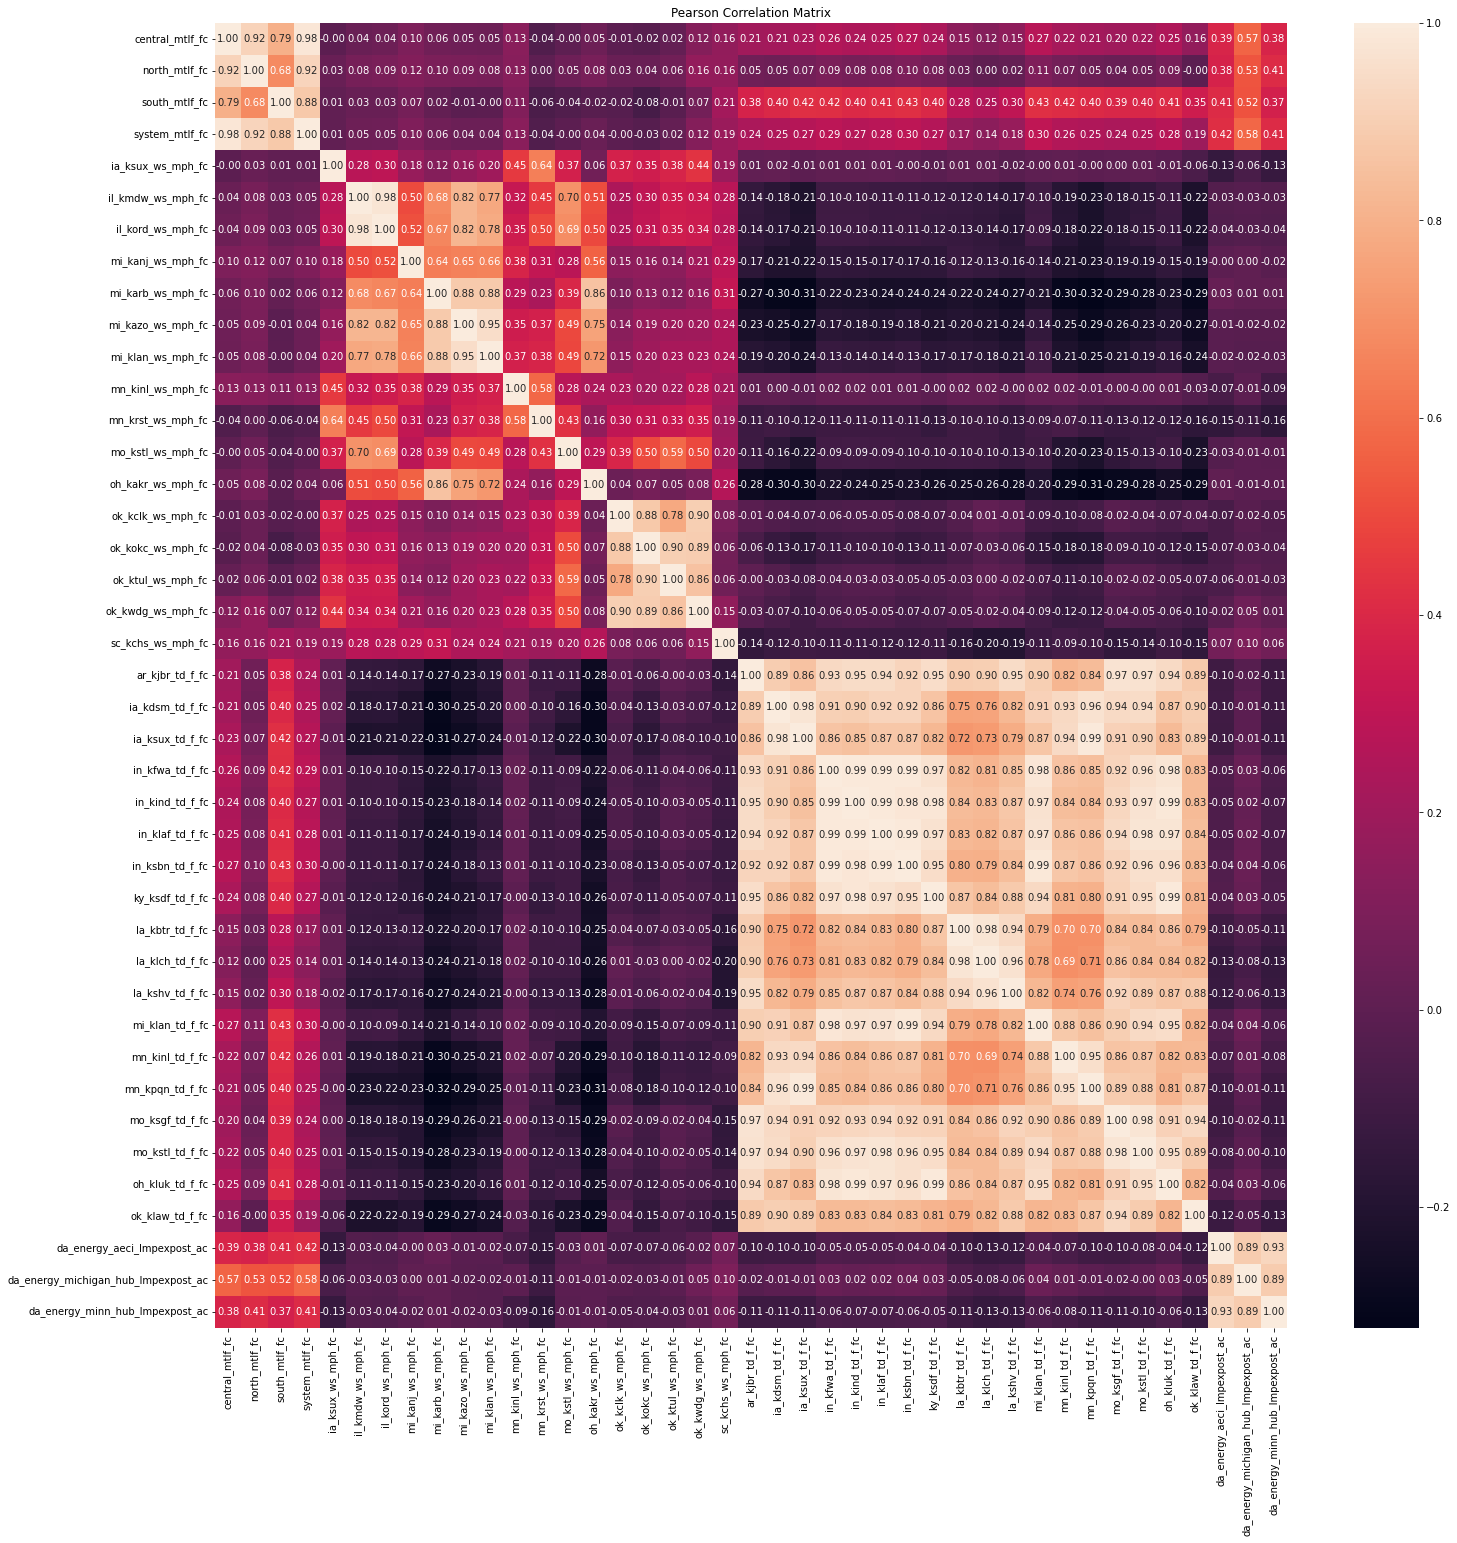

central_mtlf_fc    system_mtlf_fc       0.983202
system_mtlf_fc     central_mtlf_fc      0.983202
il_kmdw_ws_mph_fc  il_kord_ws_mph_fc    0.978281
il_kord_ws_mph_fc  il_kmdw_ws_mph_fc    0.978281
ar_kjbr_td_f_fc    mo_ksgf_td_f_fc      0.969341
                   mo_kstl_td_f_fc      0.967072
ia_kdsm_td_f_fc    ia_ksux_td_f_fc      0.977686
                   mn_kpqn_td_f_fc      0.964241
ia_ksux_td_f_fc    ia_kdsm_td_f_fc      0.977686
                   mn_kpqn_td_f_fc      0.989953
in_kfwa_td_f_fc    in_kind_td_f_fc      0.990898
                   in_klaf_td_f_fc      0.993118
                   in_ksbn_td_f_fc      0.992090
                   ky_ksdf_td_f_fc      0.966072
                   mi_klan_td_f_fc      0.983573
                   mo_kstl_td_f_fc      0.960656
                   oh_kluk_td_f_fc      0.978424
in_kind_td_f_fc    in_kfwa_td_f_fc      0.990898
                   in_klaf_td_f_fc      0.993981
                   in_ksbn_td_f_fc      0.982093
                   k

In [13]:
# Plot Pearson correlation matrix
correlations = df.corr(method='pearson')
fig = plt.figure(figsize=(24, 24))
sns.heatmap(correlations, annot=True, fmt='.2f')
plt.title('Pearson Correlation Matrix')
plt.show()

highly_correlated = abs(correlations[correlations > 0.95])
print(highly_correlated[highly_correlated < 1.0].stack().to_string())


## 2.5 Feature Engineering


### 2.5.1 Feature Generation

We can generate some necessary feature for predictions, such as:
- month, weekday, hour, etc 
- min/max temperature, temperatur range, etc
- available future predictions of temperature from weather forcasting sources, etc.

In this report, I will only add add month, weekday and hour to the features due to the limit of time.

In [14]:
# Generate 'hour', 'weekday' and 'month' features
for i in range(len(df)):
    position = df.index[i]
    hour = position.hour
    weekday = position.weekday()
    month = position.month
    df.loc[position, 'hour'] = hour
    df.loc[position, 'weekday'] = weekday
    df.loc[position, 'month'] = month

# generate weekend feature, distinguish staturday and sunday

# generate min/max temperature, temp range

# get population of each state to weight temperature?

# assume future 24 hours temperature prediction is available

### 2.5.2 Feature Selection
1. remove highly colinear features from perterson matrix. The temperatures at different locations in the same state has very high linear correlation. I will only use one temperature series for each state.
   - il_kmdw_ws_mph_fc  il_kord_ws_mph_fc
   - ia_kdsm_td_f_fc    ia_ksux_td_f_fc
   - in_kfwa_td_f_fc    in_kind_td_f_fc in_klaf_td_f_fc in_ksbn_td_f_fc 
   - la_kbtr_td_f_fc    la_klch_td_f_fc la_kshv_td_f_fc
   - mn_kinl_td_f_fc    mn_kpqn_td_f_fc
   - mo_kstl_td_f_fc    mo_ksgf_td_f_fc 
2. other dimension reduction techniques such as PCA - TODO

In [15]:
# Drop some high colinear features
df.drop(columns = ['il_kord_ws_mph_fc', 'ia_ksux_td_f_fc', 'in_kind_td_f_fc', 'in_klaf_td_f_fc', 'in_ksbn_td_f_fc', 'la_klch_td_f_fc', 'la_kshv_td_f_fc', 'mn_kpqn_td_f_fc', 'mo_ksgf_td_f_fc'], inplace=True)


# 3 Multi-variate Multi-step Time Series Forecasting

This section implemnts time-series forecasting algorithms on the given dataset to predict the electricity prices at different locations.
The prediction of 24-hour ahead electricity price under uncertainty generally falls into the typical multi-variant multi-steps probablistic forecasting problem.

Through a simple literature review, there are in generally a few uncertainties a probablistic forecasting task may consider:
- epistemic uncertain or model uncertainty, which is the uncertain in the model parameters in regions of the input space with litte data (i.e., data sparsity). we can estimate the model uncertainty to get the model prediction confidence level. Methods such as model ensemble, Bayesian nueral network, quantile regression etc can be used.
- aleator uncertainty or data uncertainty, which is the uncertainty due to data noise.
- model misspecification, which is the uncertainty about the general structure of the model. Methods such as Monte Carlo together with layer Dropouts can be applied. 

Existing open-source library `Pytorch Forecasting` has already provided various advanced probalistic features to solve this problem. 
However, ***instead of directly using high-level APIs of existing library***, I will try to build the probablistic forecasting model from scratch only based on some basic libraries.
In this report, I will mainly focus on model uncertainty, and use model ensemble method such as gradient boosting trees and Bayesian Neural Network to estimate the model parameter distributions. 

The following workflow is demonstrated in the rest of this section:
1. Non-probablistic Baseline: to help tune the probablist model in the later, I start to build a non-probabalistic baseline predictor. The XGBoost tree models are considerd for this purpose.
2. Probablistic XGBoost: here I integrated a quantile loss function to train the XGBoost model, in order to estimate a specific percentile (i.e., quantile) of the target variable.
3. Bayesian Neural Network: here i build a bayesain neural network model to estimate the distributions of model parameters.


## 3.1 Non-probablistic Baseline
A XGBoost model is used to predict the 24-hours ahead electricity price. 
The detailed implementation and result discussion can be referred to [test_xgb.ipynb](test_xgb.ipynb). 

## 3.2 XGBoost-based Quantile Regression
This section expands the non-probablistic XGBoost model to support quantile regression. 
This test is highly inspired by an example at https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_quantile.html.
The detailed implementation and results are discussed at [test_xgb.ipynb](test_xgb.ipynb). 

## 3.3 Bayesian Neural Network
This section implements a bayesian nerual network model in pytorch to perform probalistic forecasting.
Details can be referred to [test_bnn.ipynb](test_bnn.ipynb). 

# 4 Conclusion and Limitations

This report performs a multi-variate multi-steps time series probablistic forecasting for energy prices in the electric market.
Data clearning and feature engineering were performed before model training.
Two probalistic forecasting methods were implemented and compared. 

For the non-probalistic prediction, the accuracy metric such as squared error is used. 
For the quantile regression, quantile loss function based on given quantile is used.
For Bayesian nueral network, the common maximum likelihood function is used.

However, due to the large training and tuning time, I only forecasted future 6-hour ahead price instead of 24-hour ahead. 
24-hour ahead prices should be able to be predicted if more tuning and training resources are available.